In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
#Importing required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from darts import TimeSeries

%matplotlib inline

In [54]:
file_path = '../../../raw_data/processed/'
station_name = 'brushfield_street__liverpool_street'

In [55]:
df= pd.read_csv(file_path+f'processed_all_{station_name}_2020-01-01_2023-06-19_full_data_4.csv')

In [56]:
df.shape

(30361, 25)

In [57]:
df.dtypes

startdate                               object
elisabeth_line                           int64
lockdown                                 int64
strike                                   int64
school_holidays                          int64
daytime                                  int64
London_zone_Central                    float64
London_zone_North                      float64
London_zone_West                       float64
London_zone_South_West                 float64
London_zone_South_East                 float64
London_zone_East                       float64
Event                                  float64
temperature                            float64
rainfall                               float64
snowfall                               float64
cloudcover                             float64
wind_speed                             float64
wind_direction                         float64
year                                     int64
month                                    int64
day          

In [58]:
df['startdate'] = pd.to_datetime(df['startdate']).dt.tz_localize(None)

In [59]:
series = TimeSeries.from_dataframe(df, time_col='startdate', value_cols=station_name,
                                   fill_missing_dates=True, freq='H', fillna_value=0)

<Axes: xlabel='startdate'>

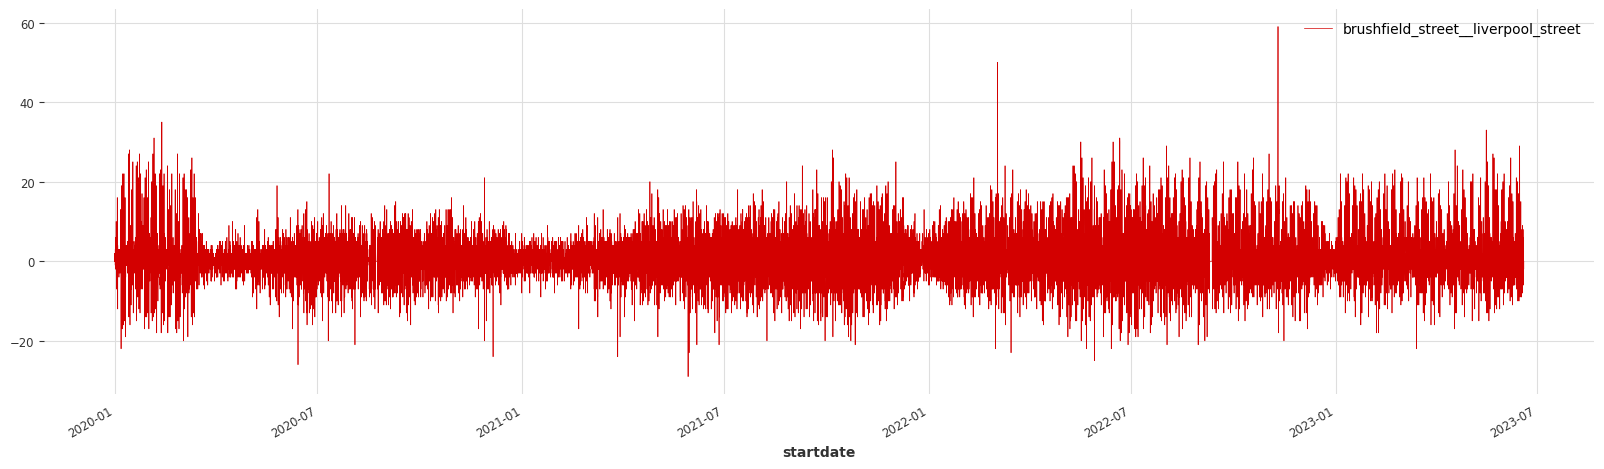

In [60]:
plt.figure(figsize=(20, 5))
series.plot(c='#D30000',linewidth=0.5)

<Axes: xlabel='startdate'>

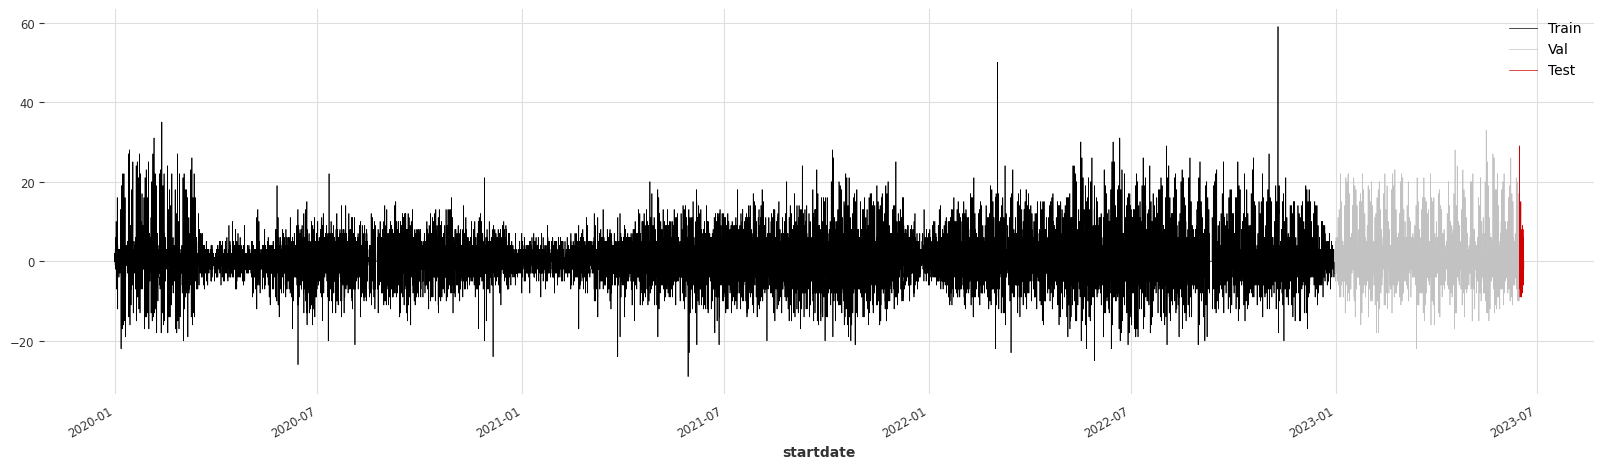

In [61]:
train, valt = series.split_before(pd.Timestamp('20221231'))
val, test = valt.split_before(pd.Timestamp('20230615'))
plt.figure(figsize=(20, 5))
train.plot(linewidth=0.5, label='Train')
val.plot(linewidth=0.5, label='Val', c='#C2C2C2')
test.plot(linewidth=0.5, label='Test', c='#D30000')


<Axes: xlabel='startdate'>

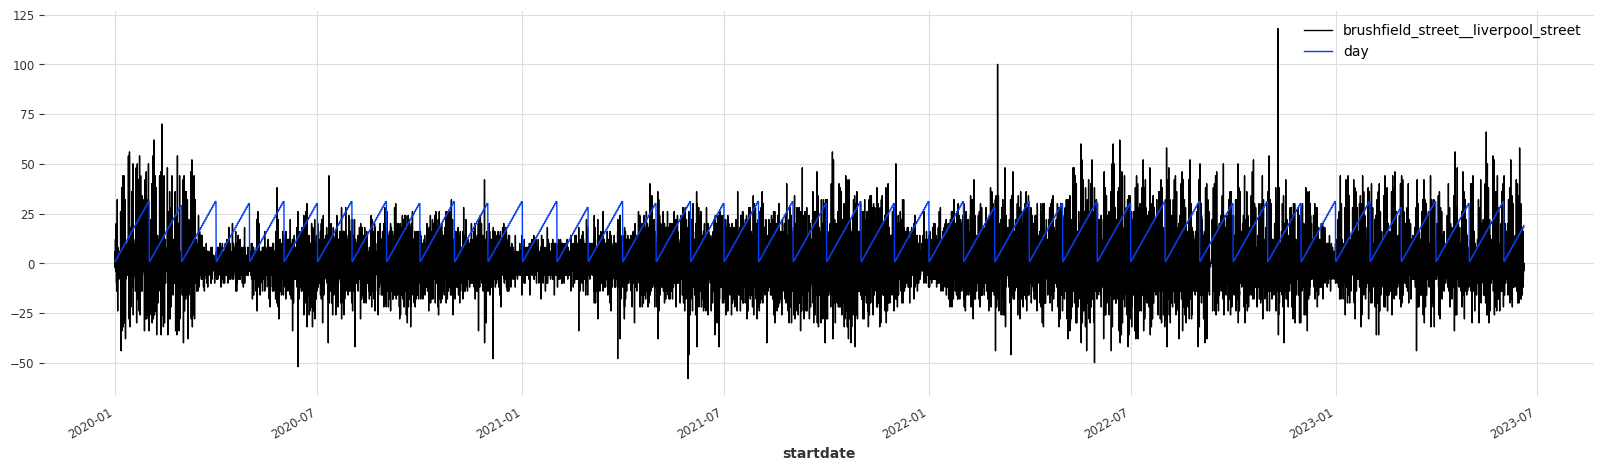

In [62]:
plt.figure(figsize=(20, 5))
(series / 0.5).add_datetime_attribute("day").plot(linewidth=1)

<Axes: xlabel='startdate'>

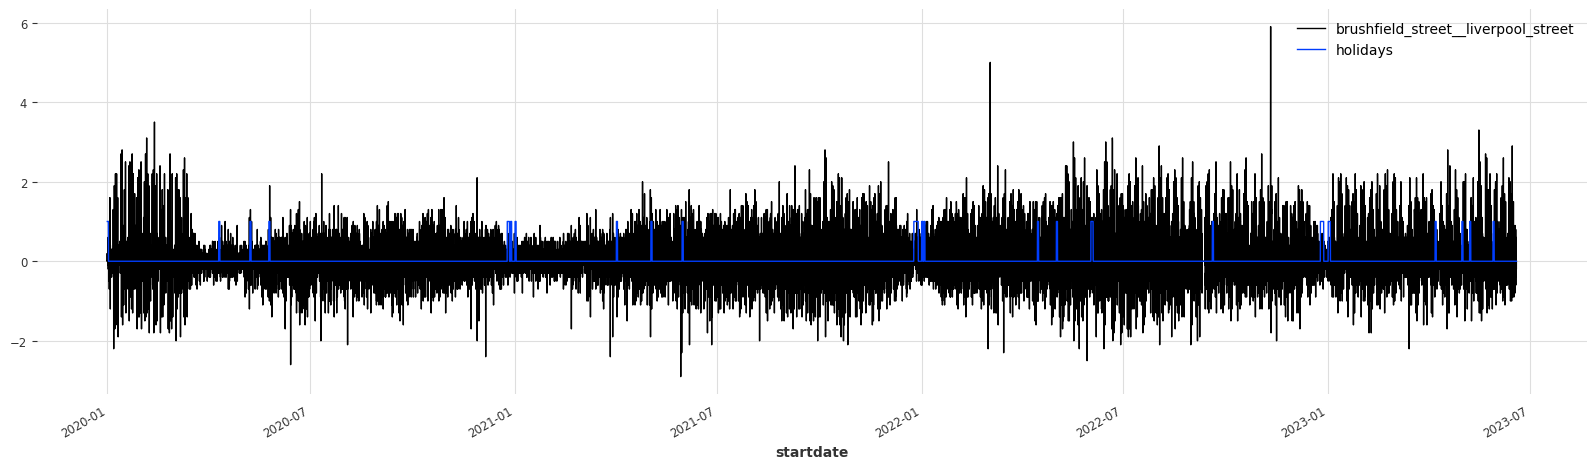

In [63]:
plt.figure(figsize=(20, 5))
(series / 10).add_holidays("UK").plot(linewidth=1)

In [ ]:
from darts.models import NaiveSeasonal

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality
plot_acf(train, m=24, alpha=0.05)

In [ ]:
try_periods = []
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
        try_periods.append(period)

In [30]:
covariates = ['elisabeth_line', 'lockdown','strike', 'school_holidays', 'daytime', 'London_zone_Central',
       'London_zone_North', 'London_zone_West', 'London_zone_South_West',
       'London_zone_South_East', 'London_zone_East', 'Event', 'temperature',
       'rainfall', 'snowfall', 'cloudcover', 'wind_speed', 'wind_direction',
       'year', 'month', 'day', 'hour', 'weekday']

In [31]:
cov_series = TimeSeries.from_dataframe(df, time_col='startdate', 
                                       value_cols=covariates, 
                                       fill_missing_dates=True, freq='H', fillna_value=0)

In [32]:
train_cov, valt_cov = cov_series.split_before(pd.Timestamp('20221231'))
val_cov, test_cov = valt_cov.split_before(pd.Timestamp('20230615'))

In [33]:
trainval_cov = train_cov.append(val_cov)

In [ ]:
plt.figure(figsize=(20, 5))
cov_series[-168:]['daytime'].plot(linewidth=1, label="true")
series[-168:].plot(linewidth=1, label="prediction", c='#D30000')

In [ ]:
seasonal_model = NaiveSeasonal(K=24)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

In [41]:
trainval = train.append(val)

In [ ]:
plt.figure(figsize=(20, 5))
trainval[-168:].plot(linewidth=1, label="actual")
seasonal_forecast[-168:].plot(linewidth=1, label="naive forecast (K=24)", c='#D30000')

In [ ]:
combined_forecast = seasonal_forecast - train.last_value()

In [44]:
from darts.metrics import mse

In [ ]:

print(
    "Mean absolute error for the combined naive seasonal: {:.2f}%.".format(
        mse(series, combined_forecast)
    )
)

In [35]:
from darts.models import Prophet, ExponentialSmoothing, AutoARIMA, NBEATSModel, RNNModel

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [ ]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mse(val, forecast)))

In [ ]:
eval_model(Prophet(add_seasonalities={
        'name':"daily_seasonality",
        'seasonal_periods':24,
        'fourier_order':1
        }))

In [ ]:
eval_model(ExponentialSmoothing(seasonal_periods=24))

In [36]:
model_es = ExponentialSmoothing(trend=None, seasonal_periods=24*7, method='TNC', optimized=True)

In [37]:
model_es.fit(train)

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=168, random_state=0, method=TNC, optimized=True)

In [38]:
pred_es = model_es.predict(n=len(val))

In [39]:
len(val)

3984

<Axes: xlabel='startdate'>

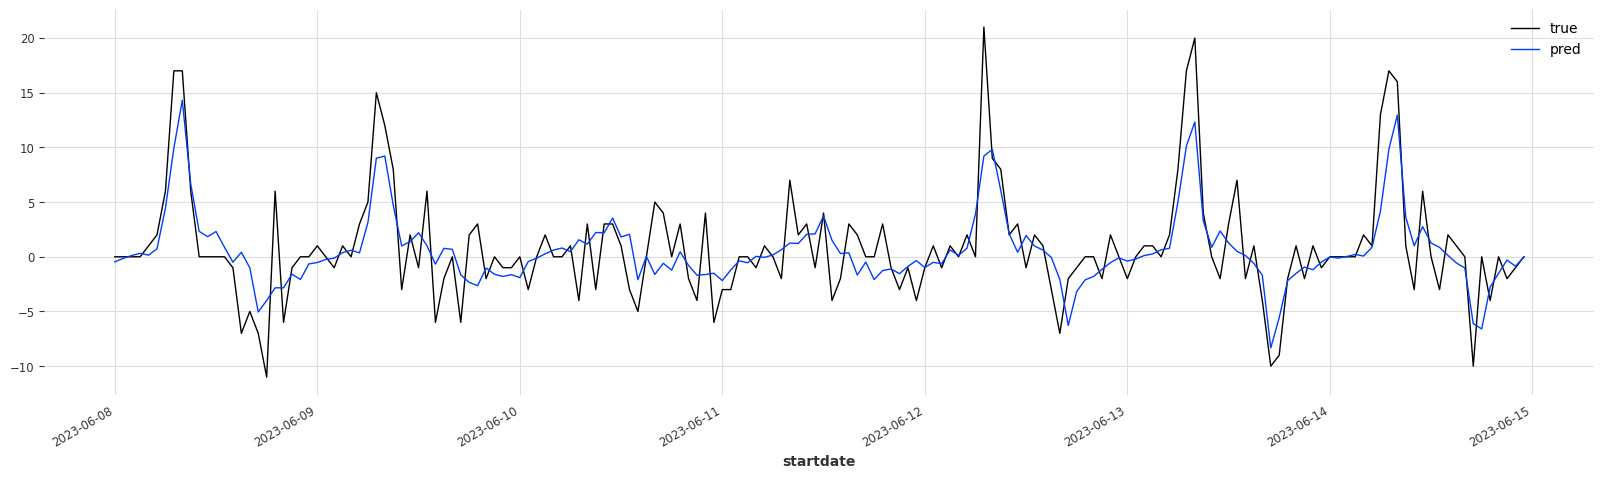

In [42]:
plt.figure(figsize=(20, 5))
trainval[-168:].plot(linewidth=1, label="true")
pred_es[-168:].plot(linewidth=1, label="pred")

In [45]:
print("model {} obtains MAPE: {:.2f}%".format(model_es, mse(val, pred_es)))

model ExponentialSmoothing(trend=None, seasonal_periods=168, method=TNC, optimized=True) obtains MAPE: 10.16%


In [46]:
pred = model_es.predict(n=len(val)+len(test))

In [47]:
len(test)

97

<Axes: xlabel='startdate'>

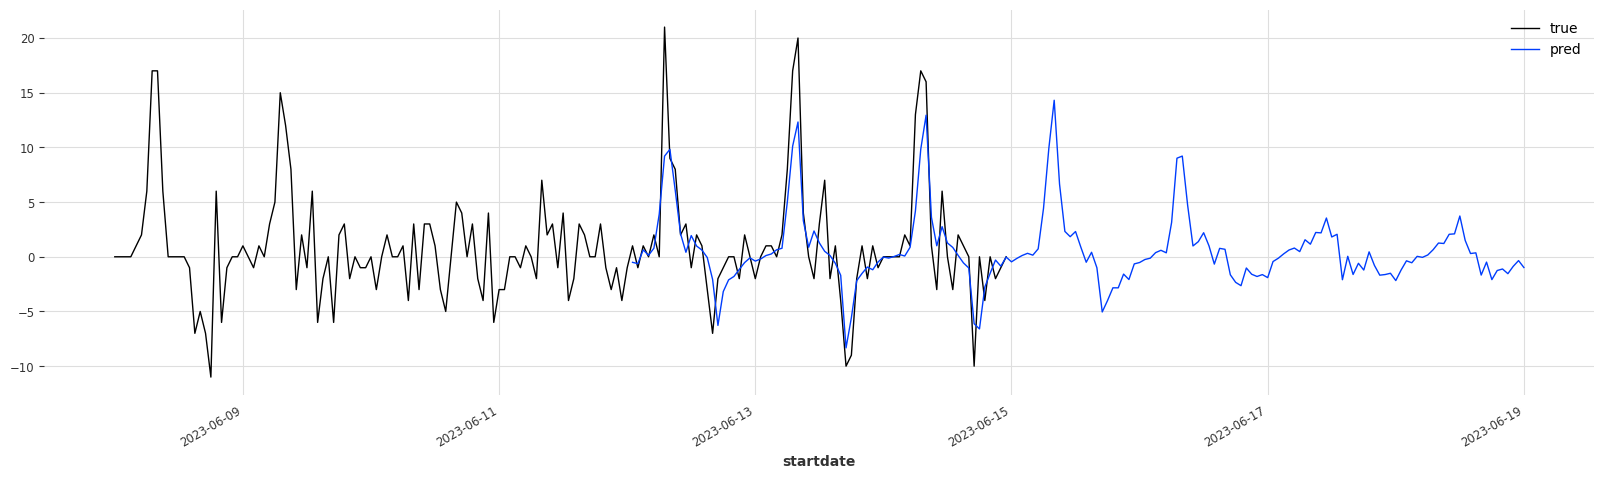

In [48]:
plt.figure(figsize=(20, 5))
trainval[-168:].plot(linewidth=1, label="true")
pred[-168:].plot(linewidth=1, label="pred")


In [50]:
from londonbss.ml_logic.registry import save_model

In [51]:
save_model(model_es,station_name)

✅ Model saved locally
✅ Model saved to GCS


In [ ]:
model_es.save(f"../../../raw_data/models/{station_name}_model.pkl")

In [ ]:
from darts.datasets import WeatherDataset
from darts.models import RNNModel

In [ ]:
model_rnn = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=24*7,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Bike_RNN",
    log_tensorboard=False,
    input_chunk_length=24*7*4,
    force_reset=True,
    save_checkpoints=True,
    random_state=42,
)

In [ ]:
model_rnn.fit(train,
    future_covariates=trainval_cov,
    val_series=val,
    val_future_covariates=trainval_cov,
    verbose=True,
)

In [ ]:
pred_rnn = model_rnn.predict(n=len(val), future_covariates=trainval_cov)

In [ ]:
print("model {} obtains MAPE: {:.2f}%".format(model_rnn, mse(val, pred_rnn)))

In [ ]:
plt.figure(figsize=(20, 5))
trainval[-168:].plot(linewidth=1, label="true")
pred_rnn[-168:].plot(linewidth=1, label="pred")

In [ ]:
best_model = RNNModel.load_from_checkpoint(model_name="Bike_RNN", best=True)

In [ ]:
pred_rnn = best_model.predict(n=len(val), future_covariates=trainval_cov)

In [ ]:
plt.figure(figsize=(20, 5))
trainval[-168:].plot(linewidth=1, label="true")
pred_rnn[-168:].plot(linewidth=1, label="pred")

In [ ]:
from darts.models import NBEATSModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12)

In [ ]:
model.fit(
    train,
    past_covariates=cov_series,
    epochs=50,
    verbose=True,
)

In [ ]:
pred = model.predict(series=train, n=len(val))

In [ ]:
plt.figure(figsize=(20, 5))
trainval[-168:].plot(linewidth=1, label="true")
pred[-168:].plot(linewidth=1, label="pred")

In [ ]:
print("model {} obtains MAPE: {:.2f}%".format(model, mse(val, pred)))

In [ ]:
pred = model.predict(series=train, n=len(val)+len(test))

In [ ]:
plt.figure(figsize=(20, 5))
trainval[-168:].plot(linewidth=1, label="true")
pred[-168:].plot(linewidth=1, label="pred")


In [ ]:
model.save("my_model2.pkl")

In [ ]:
model_loaded = NBEATSModel.load("my_model2.pkl")

In [ ]:
pred = model_loaded.predict(series=train, n=len(val))

In [ ]:
plt.figure(figsize=(20, 5))
traintest[-168:].plot(linewidth=1, label="true")
pred[-168:].plot(linewidth=1, label="pred")